In [1]:
#function to generate images with only path specification required
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def imggen(im_path):
    img=mpimg.imread(im_path)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [2]:
from sklearn.datasets import fetch_openml

mnist= fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# x,y= mnist['data'], mnist['target']
X,y=mnist.data, mnist.target
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
X = mnist.data.to_numpy()
y = mnist.target.to_numpy().astype(int)


In [5]:
type(X)

numpy.ndarray

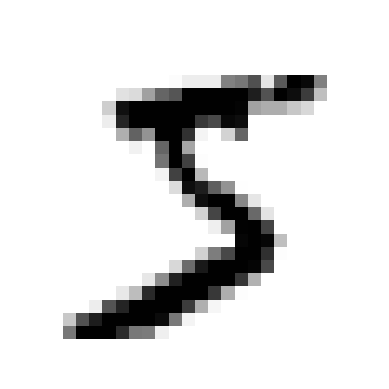

In [6]:
import matplotlib as mtp
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')  # Fixed: this should be a function call, not assignment
plt.show()

In [7]:
y[0]

5

In [8]:
X_train,X_test,y_train,y_test= X[:60000],X[60000:],y[:60000],y[60000:]

training a sgd classifier to classify just 1 digit- 5

In [9]:
y_train_5= (y_train==5)
y_test_5=(y_test==5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf= SGDClassifier(random_state=42) #random state is set for reproducible results
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

|| works correctly ||

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train,y_train_5):
    sgd_clf_pred=clone(sgd_clf)
    X_train_split=X_train[train_index]
    y_train_5_split=y_train_5[train_index]
    X_test_split=X_train[test_index]
    y_test_5split=y_train_5[test_index]

    sgd_clf_pred.fit(X_train_split,y_train_5_split)
    y_pred= sgd_clf_pred.predict(X_test_split)
    right= sum(y_pred==y_test_5split)
    accuracy= right/len(y_pred)
    print(accuracy)

0.95035
0.96035
0.9604


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

BaseEstimator is a base class in scikit-learn (sklearn) that gives structure and convenience methods to all estimators — models, transformers, etc.

Let’s break it down simply:


In sklearn, almost every model you use — like LinearRegression, RandomForestClassifier, StandardScaler, etc. — inherits from BaseEstimator. It ensures that all these models behave consistently.


Here’s what it mainly provides:
Parameter handling
It gives you built-in get_params() and set_params() methods.
So when you do things like grid search or pipeline tuning, sklearn can easily read and modify parameters because BaseEstimator standardizes how they're stored.


A common interface
Every sklearn estimator must have .fit() and often .predict(), .transform(), or .score().
BaseEstimator doesn’t implement these methods itself — it just ensures subclasses follow the same pattern.

In [14]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, X, y=None):
        return np.zeros((len(X),1),dtype=bool)

In [15]:
never5=Never5classifier()
cross_val_score(never5,X_train,y_train_5,cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

as we see we got 90% accuracy over sth that just labels not 5, its cause only 10% of the data has 5 as label, so if all are not 5, we still get high accuracy, this is why 'accuracy' is not a good performance metric, especially for skewed datasets

In [16]:
# CONFUSION MATRIX- A better way to look at the performante
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
# # Visualize the confusion matrix directly
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # Assuming y_train_5 and y_train_pred are already defined in your code
# # y_train_5 should be the true labels
# # y_train_pred should be the predicted labels from your model

# # Get the confusion matrix from the previous cell
# cm = confusion_matrix(y_train_5, y_train_pred)

# # Create a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['Not 5', '5'], 
#             yticklabels=['Not 5', '5'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

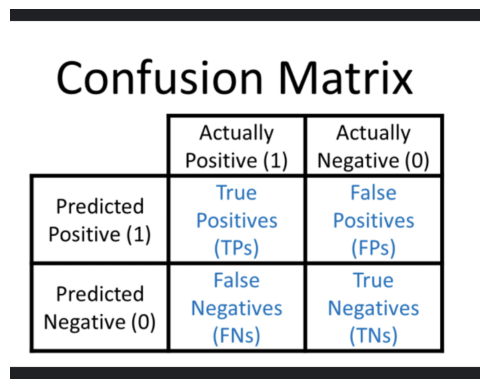

In [18]:
imggen('confusion.png')

### in a confusion matrix- 

a row represents an actual class and a column represents a predicted class
